In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import seaborn as sns
import torch

# Experiments about Table-GAN

In [ ]:
from ShadowSynthesizer import ShadowSynthesizer
from data_preprocess.adult import adult_preprocess
from data_preprocess.transformer import BaseTransformer
from sklearn.model_selection import train_test_split

df_adult = pd.read_csv('./dataset/combined_set.csv')
data, con_vars = adult_preprocess(df_adult)

train_data, test_data = train_test_split(data, test_size=0.3, random_state=2)
tf = BaseTransformer(train_data,con_vars)
ganinput = tf.transform()
print("Gan input shape:", ganinput.shape)
gan = ShadowSynthesizer(epochs = 300,seed=1,DP = False,batch_size = 500)
    #gan.fit(ganinput,tf.data_info)
myD = gan.fit(ganinput,tf.data_info)

In [5]:
#tf.scaler.fit(train_data[tf.con_vars])
#tf.enc.fit(train_data[tf.cat_vars])
#trainsform testdata
test_data = test_data[tf.columns_name]
con_columns = tf.scaler.transform(test_data[tf.con_vars])
cat_columns = tf.enc.transform(test_data[tf.cat_vars]).toarray()
test = np.column_stack((con_columns,cat_columns))

In [22]:
from sklearn.preprocessing import OrdinalEncoder
from utils import adult_postprocess
from Attack_experiment import add_true_label
def add_label_to_syn(gan,tf,Discriminator):
    samples = gan.sample(n=gan.ganinput.shape[0])
    data_inverse = tf.inverse_transform(samples)
    syn = pd.DataFrame(data_inverse,index=None,columns = tf.columns_name)
    syn = adult_postprocess(syn)
    syn_test = syn[tf.columns_name]
    con_columns = tf.scaler.transform(syn_test[tf.con_vars])
    cat_columns = tf.enc.transform(syn_test[tf.cat_vars]).toarray()
    syn_test = np.column_stack((con_columns,cat_columns))
    #load training data
    data_inverse = tf.inverse_transform(ganinput)
    real = pd.DataFrame(data_inverse,index=None,columns = tf.columns_name)
    real = adult_postprocess(real)
    
    enc = OrdinalEncoder()
    colomns =['WorkClass', 'EducationNum', 'MaritalStatus', 'Occupation',
       'Relationship', 'Race', 'Gender', 'CapitalGain', 'CapitalLoss',
       'HoursPerWeek', 'NativeCountry', 'Income']
    real[colomns] = enc.fit_transform(real[colomns])
    syn[colomns] = enc.fit_transform(syn[colomns])
    new_syn = add_true_label(real,syn)
    label = new_syn.pop('label')
    
    syn_test =torch.from_numpy(syn_test.astype('float32')).to(gan.device)
    D_in_pred = Discriminator(syn_test)
    syn_test = torch.cat([syn_test,D_in_pred],dim =1).detach().cpu().numpy()
    return syn_test, label

In [23]:
syn, label =add_label_to_syn(gan,tf,myD)


Begin sample，seed= 0
Inverse transform completed!
Inverse transform completed!
(28411, 13)


In [6]:
def MI_attack(Discriminator,D_in,D_out):
    D_in = torch.from_numpy(D_in[0:10000].astype('float32')).to(gan.device)
    D_out = torch.from_numpy(D_out[0:10000].astype('float32')).to(gan.device)

    D_in_pred = Discriminator(D_in)
    D_out_pred = Discriminator(D_out)

    D1 = torch.cat([D_in,D_in_pred],dim =1)
    D2 = torch.cat([D_out,D_out_pred],dim =1)

    label_in = torch.ones(10000,1).to(gan.device)
    label_out = torch.zeros(10000,1).to(gan.device)

    D1 = torch.cat([D1,label_in],dim =1).detach().cpu().numpy()
    D2 = torch.cat([D2,label_out],dim =1).detach().cpu().numpy()
    dataset = np.concatenate([D1,D2],axis=0)
    return dataset
dataset = MI_attack(myD,ganinput,test)

In [7]:
from sklearn.model_selection import train_test_split
from MLclassifier import main
from sklearn.neural_network import MLPClassifier

y = dataset[:,-1]
X = np.delete(dataset,-1,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=2)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
classifier = MLPClassifier(hidden_layer_sizes=(100, ),max_iter = 200)
classifier.fit(X_train, y_train)

(14000, 109) (6000, 109) (14000,) (6000,)


C:\Users\HAT\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

(0.0, 1.05)

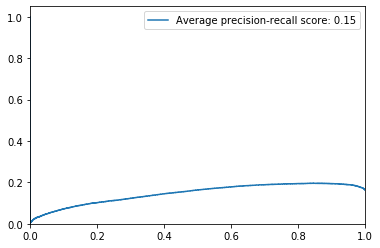

In [37]:
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
y_score = classifier.predict_proba(syn)[:,1]
precision, recall, thresholds = precision_recall_curve(label, y_score)
AUC = metrics.auc(recall,precision)
plt.plot(recall,precision,label='Average precision-recall score: {0:0.2f}'.format(
      AUC))
plt.legend()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

In [35]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(label, y_score)
average_precision

0.14632356424093912

In [33]:
AUC

0.14628592440292418

In [ ]:
from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from Attack_experiment import unique_exam,compute_intersection,add_true_label
from sklearn import metrics

def train_classifier(train):
    train = train.drop(columns=['counts_in_real'])
    y_train = train.pop('label')
    X_train = train.values
    #classifier = svm.LinearSVC(random_state=random_state)
    #classifier.fit(X_train, y_train)
    classifier = MLPClassifier(hidden_layer_sizes=(100, ),max_iter = 200)
    classifier.fit(X_train, y_train)
    
    return classifier

def predict_prob(model,test):
    test  = test.drop(columns=['counts_in_real'])
    y_test = test.pop('label')
    X_test = test.values
    y_score = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    AUC = metrics.auc(recall,precision)
    return precision, recall, thresholds,AUC

In [14]:
from sklearn.preprocessing import OrdinalEncoder
def load_adult_epoches_for_ml(seed):
    real = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)
    
    test = pd.read_csv('./GenerateData/Adult/Adult_test.csv')
    test = ordinal_encode(enc,test)
    
    syn = pd.read_csv('./GenerateData/Adult/epoch'+str(seed)+'/adult_syn_seed1_'+'epoch'+str(300)+'.csv') 
    syn = ordinal_encode(enc,syn)

    return real, syn

In [7]:
def ordinal_encode(enc,data):
    colomns = [col for col in data.columns if data[col].dtype=="object"]
    data[colomns] = enc.fit_transform(data[colomns])
    return data
def cut_dataset(dataset,n,perlen):
    np.random.seed(3000)
    sub_fake = []
    rand_ind = np.random.permutation(perlen*n)
    for i in range(n):
        indices = rand_ind[perlen*i : perlen*i + perlen]
        sub_fake.append(dataset.iloc[indices]) 
    return sub_fake

In [15]:
from Attack_experiment import unique_exam,compute_intersection,add_true_label,train_classifier
real, syn = load_adult_epoches_for_ml(seed=1)
new_syn = add_true_label(real,syn)

(28238, 13)


In [16]:
new_syn.head()

,Age,WorkClass,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income,freq,counts_in_real,label
0,40.0,2.0,7.0,0.0,6.0,0.0,4.0,1.0,2.0,2.0,17.0,1.0,0.0,2,0,0
1,36.0,2.0,9.0,0.0,4.0,0.0,4.0,1.0,2.0,2.0,20.0,0.0,0.0,1,0,0
2,21.0,2.0,9.0,1.0,2.0,4.0,4.0,1.0,2.0,2.0,22.0,1.0,0.0,1,1,1
3,31.0,2.0,10.0,1.0,7.0,1.0,4.0,0.0,2.0,2.0,17.0,1.0,0.0,1,2,1
4,40.0,4.0,10.0,0.0,3.0,5.0,2.0,0.0,2.0,2.0,24.0,1.0,1.0,1,0,0


In [26]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
y = new_syn.freq.values
X = new_syn.drop(columns=['freq','counts_in_real','label']).values
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.3, shuffle=False)
reg = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
reg.score(X_test, y_test)

0.32623566162828455

In [44]:
#train attack model

from sklearn.neural_network import MLPClassifier
from Attack_experiment import unique_exam,compute_intersection,add_true_label
from sklearn import metrics

def load_epoches_adult(seed):
    real = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
    enc = OrdinalEncoder()
    real = ordinal_encode(enc,real)

    syn = pd.read_csv('./GenerateData/Adult/epoch'+str(seed)+'/adult_syn_seed1_'+'epoch'+str(300)+'.csv')
    syn = ordinal_encode(enc,syn)

    shadow = pd.read_csv('./GenerateData/Adult/epoch'+str(seed)+'/adult_shadow_seed1_'+'epoch'+str(300)+'.csv')
    shadow = ordinal_encode(enc,shadow)

    return real,syn,shadow

def train_classifier(train):
    train = train.drop(columns=['counts_in_real'])
    y_train = train.pop('label')
    X_train = train.values
    print(X_train.shape)
    #classifier = svm.LinearSVC(random_state=random_state)
    #classifier.fit(X_train, y_train)
    classifier = MLPClassifier(hidden_layer_sizes=(100, ),max_iter = 200)
    classifier.fit(X_train, y_train)
    return classifier


real,syn,shadow = load_epoches_adult(seed=1)
#new_syn = add_true_label(real,syn)
new_shadow = add_true_label(syn,shadow)
classifier= train_classifier(new_shadow)





(28136, 13)
(31655, 14)


In [58]:
#Preparing testing data
D_in = pd.read_csv('./GenerateData/Adult/Adult_train.csv') 
enc = OrdinalEncoder()
real = ordinal_encode(enc,D_in)
D_out = pd.read_csv('./GenerateData/Adult/Adult_test.csv')
D_out = ordinal_encode(enc,D_out)

X = pd.concat([D_in[:10000],D_out[:10000]])
X = np.concatenate((X,freq_pred.reshape(-1,1)), axis=1)

y = np.concatenate((np.zeros(10000),np.ones(10000)), axis=0)

In [66]:
from sklearn.metrics import roc_auc_score
def predict_prob(model,X_test,y_test):
    y_score = model.predict_proba(X_test)[:,1]
    AUCROC = roc_auc_score(y_test,y_score)
    #precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    #AUC = metrics.auc(recall,precision)
    return AUCROC

In [56]:
freq_pred = reg.predict(X.values)

In [68]:
AUCROC = predict_prob(classifier,X,y)

In [69]:
AUCROC

0.50081571